# Demonstration of PyCUDA with Project Euler
## Problem 27 - Quadratic Primes

Explanation of the problem, link to Project Euler

## CPU Python implementation

In [1]:
import numpy as np
from time import time as timer

We will use the following helper functions which check whether a number is a prime ('is_prime') and compute all the primes less than a certain N ('primes_less_than')

In [2]:
def is_prime(n):
    if n == 1:
        return False
    if n == 2:
        return True
    if n == 3:
        return True
    if n % 2 == 0:
        return False
    if n % 3 == 0:
        return False
    i = 5
    w = 2
    while i*i<=n:
        if n % i == 0:
            return False
        i += w
        w = 6 - w
    return True

def primes_less_than(n):
    primes = []
    for i in np.arange(2,n):
        if is_prime(i):
            primes.append(i)
    return primes

We will compute sequentially on the CPU the maximum amount of primes generated by each combination of $a$ and $b$, and we will time the code

In [3]:
a = np.arange(-999, 1000, 2).astype(np.int32)  # only consider odd numbers
b = np.array(primes_less_than(1001)).astype(np.int32)  # only consider primes

agrid, bgrid = np.meshgrid(a,b)
af = agrid.flatten()
bf = bgrid.flatten()

In [4]:
primes = []
a_s = []
b_s = []
start_cpu = timer()
for (ai, bi) in zip(af,bf):
    n = np.int32(0)
    while True:
        p = n**2 + ai*n + bi
        if p<1:
            break
        else:
            if not is_prime(p):
                primes.append(n)
                a_s.append(ai)
                b_s.append(bi)
                break
            else:
                n += 1
                
result = max(primes)                
end_cpu = timer()
speed_cpu = end_cpu - start_cpu
print('CPU code took %f seconds' %speed_cpu)
print('The maximum amount of primes is %d' %result)

CPU code took 1.506981 seconds
The maximum amount of primes is 71


## GPU PyCUDA implementation

Checking over all combinations of $a$ and $b$ sequentially is not the smartest thing to do, as each case is completely independent and can run in parallel. Therefore, we will use PyCUDA to show that the speed of the code can be increased significantly by using GPU computing

In [5]:
import pycuda.autoinit
import pycuda.driver as drv
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule

The first step is to translate the Python code into a C version suitable for CUDA. For this we need two functions:

1) The main CUDA $kernel$ 'count_primes' which counts the number of primes generated for a set of $a$, $b$. This kernel runs in parallel for each thread

2) The $device$ function 'is_prime' which is used by the main CUDA kernel to check if a number is prime

In [6]:
mod = SourceModule("""
#include <stdio.h>

__device__ int is_prime(int n){
if(n <= 1){return 0;}
if(n == 2){return 1;}
if(n == 3){return 1;}
if(n % 2 == 0){return 0;}
if(n % 3 == 0){return 0;}
int i = 5;
int w = 2;
while (i*i <= n){
    if (n % i == 0){
        return 0;
    }
    i = i + w;
    w = 6 - w;
}
return 1;
}

__global__ void count_primes(int *a, int *b)
{
const int idx = blockIdx.x * blockDim.x * blockDim.y + threadIdx.y * blockDim.x + threadIdx.x;
int ai = a[idx];
int bi = b[idx];
int n = 0;
const int nmax = 1000;
for(n=0; n<nmax; n+=1){
    int p = n*n + ai*n + bi;
    if(p < 1){
        b[idx] = n;
        break;
    }
    else {
        p = is_prime(p);
        if (p == 0){
            b[idx] = n;
            break;
        }
    }
}
}
""")

prime_counter_gpu = mod.get_function("count_primes")

Now we will run the code on the GPU. We will start the timer and then allocate the necessary memory on the GPU, transfer our arrays from the CPU to the GPU, run the kernel, retrieve the results and stop the timer


In [8]:
# Use copies of the arrays because the GPU will substitute the results
aa = af.copy()
bb = bf.copy()

start_gpu = timer()

# GPU memory allocation
a_gpu = drv.mem_alloc(aa.nbytes)
b_gpu = drv.mem_alloc(bb.nbytes)

# CPU to GPU data transfer
drv.memcpy_htod(a_gpu, aa)
drv.memcpy_htod(b_gpu, bb)

# Kernel launch
prime_counter_gpu(a_gpu, b_gpu, block=(125,8,1), grid=(168,1))

# GPU to CPU data transfer
drv.memcpy_dtoh(bb, b_gpu)

# Free GPU memory
b_gpu.free()
a_gpu.free()

# Check result
result = max(bb)
end_gpu = timer()


speed_gpu = end_gpu - start_gpu
print('GPU code took %f seconds' %speed_gpu)
print('The maximum amount of primes is %d' %result)



GPU code took 0.021022 seconds
The maximum amount of primes is 71


## CPU - GPU speed comparison

Wne dealing with GPU, for a meaningful speed comparison it is recommended to run the GPU cell at least a couple of times

In [9]:
ratio = speed_cpu / speed_gpu
print('The PyCUDA GPU code was around %d times faster than the Python CPU version' %(np.floor(ratio)))

The PyCUDA GPU code was around 71 times faster than the Python CPU version


Let us now study how each code scales with the dimensionality of the problem. We will start by benchmarking the CPU Python code for increasing sizes of the $a$. $b$ set

In [10]:
def cpu_solve(af, bf):
    " Solves the problem of finding the maximum number of primes for a and b using CPU Python"
    " Returns the time it has taken to compute the solution"
    primes = []
    a_s = []
    b_s = []
    start_cpu = timer()
    for (ai, bi) in zip(af,bf):
        n = np.int32(0)
        while True:
            p = n**2 + ai*n + bi
            if p<1:
                break
            else:
                if not is_prime(p):
                    primes.append(n)
                    a_s.append(ai)
                    b_s.append(bi)
                    break
                else:
                    n += 1
    result = max(primes)                
    end_cpu = timer()
    speed_cpu = end_cpu - start_cpu
    
    return speed_cpu

In [13]:
m = 4 + np.arange(8)
Nmax = 2**m   # We choose the size of 'a' as powers of 2
cpu_times = []
sizes = []
for N in Nmax:
    a = np.arange(-(N-1), (N+1), 2).astype(np.int32)  # only consider odd numbers
    b = np.array(primes_less_than(N+1)).astype(np.int32)  # only consider primes
    agrid, bgrid = np.meshgrid(a,b)
    af = agrid.flatten()
    bf = bgrid.flatten()
    sizes.append(af.shape[0])   # The meshgrid increases the total size to N^2
    cpu_times.append(cpu_solve(af,bf))

print('CPU version is finished')
    

CPU version is finished


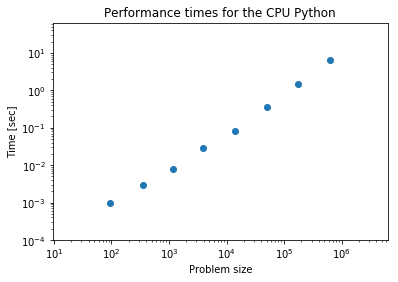

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Performance times for the CPU Python')
plt.scatter(sizes, cpu_times)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.1*min(sizes), 10*max(sizes)])
plt.ylim([0.1*min(cpu_times), 10*max(cpu_times)])
plt.xlabel('Problem size')
plt.ylabel('Time [sec]')
plt.show()

### GPU PyCUDA dimensionality benchmark

In [18]:
def gpu_solve(af, bf):
    " Solves the problem of finding the maximum number of primes for a and b using GPU PyCUDA"
    aa = af.copy()
    bb = bf.copy()

    start_gpu = timer()

    # GPU memory allocation
    a_gpu = drv.mem_alloc(aa.nbytes)
    b_gpu = drv.mem_alloc(bb.nbytes)

    # CPU to GPU data transfer
    drv.memcpy_htod(a_gpu, aa)
    drv.memcpy_htod(b_gpu, bb)

    # Kernel launch
    prime_counter_gpu(a_gpu, b_gpu, block=(125,8,1), grid=(168,1))

    # GPU to CPU data transfer
    drv.memcpy_dtoh(bb, b_gpu)

    # Check result
    result = max(bb)
    
    # Free GPU memory
    b_gpu.free()
    a_gpu.free()
    
    end_gpu = timer()
    speed_gpu = end_gpu - start_gpu
    
    return speed_gpu

In [19]:
gpu_times = []
transfer_times = []
for N in Nmax:
    a = np.arange(-(N-1), (N+1), 2).astype(np.int32)  # only consider odd numbers
    b = np.array(primes_less_than(N+1)).astype(np.int32)  # only consider primes
    agrid, bgrid = np.meshgrid(a,b)
    af = agrid.flatten()
    bf = bgrid.flatten()
    gpu_times.append(gpu_solve(af, bf))
print('GPU version is finished')

GPU version is finished


### CPU vs GPU comparison
It is interesting to see how (at low dimensionality) the cost of memory transfers between CPU and GPU makes the PyCUDA implementation much slower than the Python CPU version. Nevertheless, as the problem size grows larger, the overhead becomes negligible in comparison with the actual computational time; thus the PyCUDA implementation becomes much faster than the CPU version.

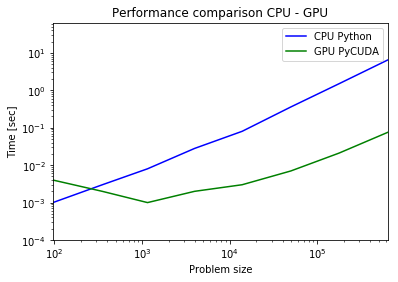

In [20]:
plt.figure()
plt.title('Performance comparison CPU - GPU')
plt.plot(sizes, cpu_times, color='blue', label='CPU Python')
plt.plot(sizes, gpu_times, color='green', label='GPU PyCUDA')
plt.xscale('log')
plt.yscale('log')
plt.xlim([min(sizes), max(sizes)])
plt.ylim([0.1*min(cpu_times), 10*max(cpu_times)])
plt.xlabel('Problem size')
plt.ylabel('Time [sec]')
plt.legend()
plt.show()